### **Importing all the Required Libraries**


In [ ]:
import tensorflow as tf
import tensorflow.keras as k
import cv2
import numpy as np

from IPython.display import Image
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
%matplotlib inline

**Downloading the images for the Pig nose Emoji and faces of people**

In [ ]:
# Trial image
# !wget https://www.sciencenewsforstudents.org/wp-content/uploads/2019/11/860_main_beauty.png
# !wget https://i.pinimg.com/736x/42/2d/d5/422dd53540defd8cb847635783f6790c.jpg
# !wget https://www.uni-regensburg.de/Fakultaeten/phil_Fak_II/Psychologie/Psy_II/beautycheck/english/kindchenschema/kindfrau_b/kindfrau_b_90_gr.jpg
# !wget https://i2-prod.mirror.co.uk/incoming/article14334083.ece/ALTERNATES/s810/3_Beautiful-girl-with-a-gentle-smile.jpg
!wget https://www.hindustantimes.com/rf/image_size_960x540/HT/p2/2020/03/06/Pictures/friends_8fe2f5a0-5fbf-11ea-be04-6cf974e2d9f7.jpg

--2020-10-22 19:37:20--  https://www.hindustantimes.com/rf/image_size_960x540/HT/p2/2020/03/06/Pictures/friends_8fe2f5a0-5fbf-11ea-be04-6cf974e2d9f7.jpg
Resolving www.hindustantimes.com (www.hindustantimes.com)... 104.99.86.254
Connecting to www.hindustantimes.com (www.hindustantimes.com)|104.99.86.254|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28853 (28K) [image/jpeg]
Saving to: ‘friends_8fe2f5a0-5fbf-11ea-be04-6cf974e2d9f7.jpg’

friends_8fe2f5a0-5f 100%[===================>]  28.18K  --.-KB/s    in 0.008s  

2020-10-22 19:37:21 (3.63 MB/s) - ‘friends_8fe2f5a0-5fbf-11ea-be04-6cf974e2d9f7.jpg’ saved [28853/28853]



### **Loading our Pretrained Keras model for Face Landmark Detection**

In [ ]:
model = k.models.load_model('/content/drive/My Drive/Colab Notebooks/Snapchat_filters/Trained_model/Best_model.h5')
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 1)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 96, 96, 256)       12800     
_________________________________________________________________
batch_normalization_7 (Batch (None, 96, 96, 256)       1024      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 96, 96, 256)       1638656   
_________________________________________________________________
batch_normalization_8 (Batch (None, 96, 96, 256)       1024      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 94, 94, 256)       590080    
_________________________________________________________________
batch_normalization_9 (Batch (None, 94, 94, 256)      

In [ ]:
def find_xy(heatmap, n):
    top_n = np.sort(heatmap.flatten())[-n:]
    top_n_locs = [np.where(heatmap == i) for i in top_n]
    top_n_locs = np.array([np.array([i[0][0], i[1][0]]) for i in top_n_locs])
    norm_top_n = top_n / np.max(top_n)
    
    y = np.sum(top_n_locs[:, 0] * norm_top_n)/np.sum(norm_top_n)
    x = np.sum(top_n_locs[:, 1] * norm_top_n)/np.sum(norm_top_n)
    
    return np.array([x, y])

def get_landmarks(predictions, n):
    landmarks = []
    
    for i, val in enumerate(predictions):
        lands = []
        for j in range(val.shape[-1]):
            xy = find_xy(predictions[i, :, :, j], n=6)
            lands.append(xy)
        landmarks.append(np.array(lands))
    landmarks = np.array(landmarks)
    landmarks = landmarks.reshape(landmarks.shape[0], -1)
    return landmarks

def scale_landmarks(land_x, land_y, box_size, cropped_img_size):
    scale_factor_x = box_size[1] / cropped_img_size[1]
    scale_factor_y = box_size[0] / cropped_img_size[0]
    
    land_x = land_x * scale_factor_x
    land_y = land_y * scale_factor_y
    return land_x, land_y

def create_nose_edge_landmarks(landmarks):
    eye_in_1 = landmarks[2]
    eye_in_2 = landmarks[4]
    nose = landmarks[10]

    nose_1 = (eye_in_1[0], nose[1])
    nose_2 = (eye_in_2[0], nose[1])
    landmarks.append(nose_1)
    landmarks.append(nose_2)
    return landmarks

In [ ]:
# Download Pig nose emoji
!wget https://s3.amazonaws.com/pix.iemoji.com/images/emoji/apple/ios-12/256/pig-nose.png

--2020-10-22 19:00:14--  https://s3.amazonaws.com/pix.iemoji.com/images/emoji/apple/ios-12/256/pig-nose.png
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.96.86
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.96.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48016 (47K) [image/png]
Saving to: ‘pig-nose.png’

pig-nose.png        100%[===================>]  46.89K  --.-KB/s    in 0.07s   

2020-10-22 19:00:14 (721 KB/s) - ‘pig-nose.png’ saved [48016/48016]



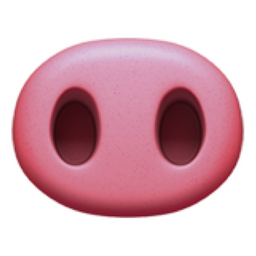

(256, 256, 3)


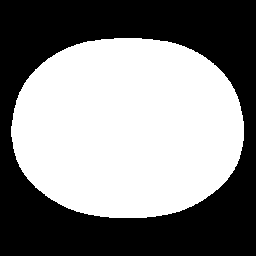

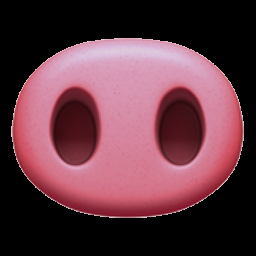

In [ ]:
pig_nose = cv2.imread('/content/pig_nose.png')
# cv2.circle(pig_nose, (80, 80), 1, (255, 255, 0), 5)
cv2_imshow(pig_nose)
print(pig_nose.shape)

pig_nose_gray = cv2.cvtColor(pig_nose, cv2.COLOR_BGR2GRAY)
_, pig_nose_mask = cv2.threshold(pig_nose_gray, 210, 255, cv2.THRESH_BINARY_INV)
cv2_imshow(pig_nose_mask)

pig_nose = cv2.bitwise_and(pig_nose, pig_nose, mask = pig_nose_mask)
cv2_imshow(pig_nose)

### **Running the model on Example Images**

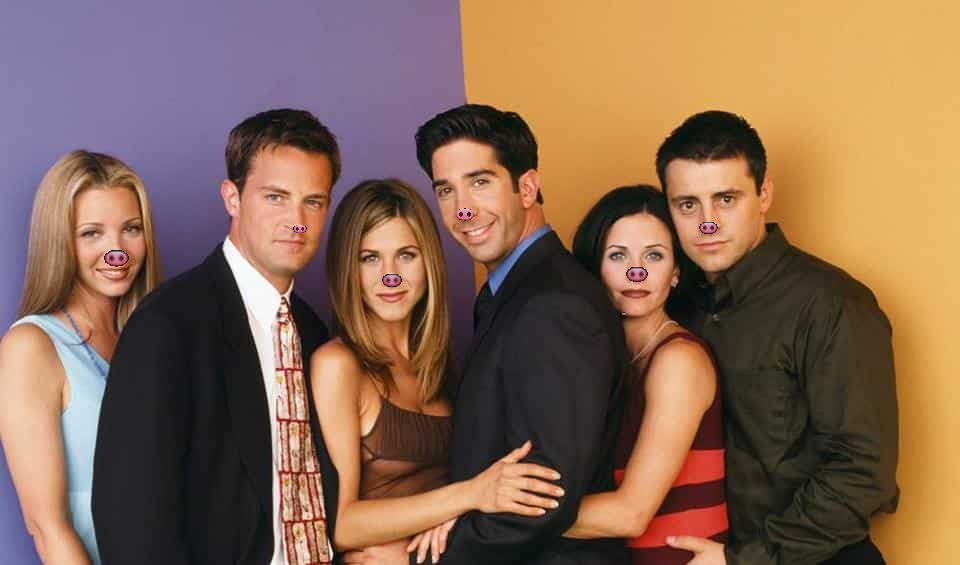

In [ ]:
fname = '/content/friends.jpg'
img = cv2.imread(fname)
img_size = img.shape[0:2]

face_cascade = cv2.CascadeClassifier('/content/drive/My Drive/Colab Notebooks/Snapchat_filters/haarcascade_frontalface_default.xml')

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(gray, 1.1, 4)

for (x, y, w, h) in faces:
    # cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 255), 3)
    crop_img = cv2.resize(np.array(gray[y:y + h, x:x + w])/255, (96, 96))
    crop_img = crop_img.reshape(1, 96, 96, 1)
    crop_img_size = crop_img.shape[1:3]
    
    landmarks = model.predict(crop_img)
    landmarks = get_landmarks(landmarks, 5)
    landmarks = landmarks[0]

    land_x = landmarks[0::2]
    land_y = landmarks[1::2]
    land_x, land_y = scale_landmarks(land_x, land_y, (h, w), crop_img_size)
    
    land_x = land_x + x
    land_y = land_y + y

    landmarks = list(zip(land_x, land_y))
    landmarks = create_nose_edge_landmarks(landmarks)

    landmarks = np.around(landmarks, 0).astype('int')
    # for i, val in enumerate(landmarks):
    #     cv2.circle(img, tuple(val), 1, (0, 255, 255), 3)
    

    # Adding the cartoon pig nose
    nose_center_loc = landmarks[10]
    nose_width = int(abs(landmarks[-1][0] - landmarks[-2][0]) * 0.8)
    nose_height = int(nose_width * 1.2)

    top_left = int(nose_center_loc[0] - nose_height / 2), int(nose_center_loc[1] - nose_width / 2)
    bottom_right = int(nose_center_loc[0] + nose_height / 2), int(nose_center_loc[1] + nose_width / 2)
        
    pig_nose = cv2.resize(pig_nose, (nose_height, nose_width))
    pig_nose_gray = cv2.cvtColor(pig_nose, cv2.COLOR_BGR2GRAY)
    _, pig_nose_mask = cv2.threshold(pig_nose_gray, 20, 255, cv2.THRESH_BINARY_INV)
    nose_area = img[top_left[1]: top_left[1] + nose_width, top_left[0]: top_left[0] + nose_height]

    nose_area_no_nose = cv2.bitwise_and(nose_area, nose_area, mask = pig_nose_mask)
    final_nose = cv2.add(pig_nose, nose_area_no_nose)

    img[top_left[1]: top_left[1] + nose_width, top_left[0]: top_left[0] + nose_height] = final_nose
    

    # cv2_imshow(nose_area)
    # cv2_imshow(nose_area_no_nose)
    # cv2_imshow(final_nose)

cv2_imshow(img)